In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

(256, 1600, 3)

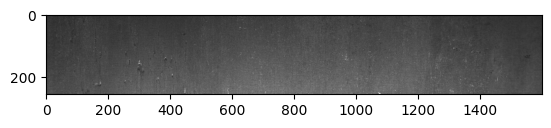

In [3]:
img = cv2.imread('/kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg')
plt.imshow(img)
img.shape

In [4]:
df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')

In [5]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
a = df.iloc[0]['EncodedPixels']

In [7]:
# 1) RLE → mask
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.array(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    flat = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        flat[lo:hi] = 1
    return flat.reshape(shape, order='F')

# 2) mask → bbox
def mask_to_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs)==0:
        return None
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    return xmin, ymin, xmax, ymax
    
# 3) bbox → YOLO format
def bbox_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    box_w = xmax - xmin
    box_h = ymax - ymin
    x_c = xmin + box_w/2
    y_c = ymin + box_h/2
    return x_c/img_w, y_c/img_h, box_w/img_w, box_h/img_h



In [8]:
img = Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg')
img_w,img_h = img.size

In [9]:
k = rle_decode(a,shape=(img_h,img_w))

In [10]:
df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
image_size = (1600, 256)  # Severstal images are 256×1600 (H×W)

for img_id, group in df.groupby('ImageId'):
    lines = []
    for _, row in group.iterrows():
        cl = int(row.ClassId) - 1
        if pd.isna(row.EncodedPixels):
            continue
        mask = rle_decode(row.EncodedPixels, image_size)
        bbox = mask_to_bbox(mask)
        if bbox is None:
            continue
        yolo_box = bbox_to_yolo(*bbox, img_w=image_size[1], img_h=image_size[0])
        lines.append(f"{cl} " + " ".join(f"{v:.6f}" for v in yolo_box))
    # save if there is at least one defect
    if lines:
        os.makedirs('labels/train', exist_ok=True)
        with open(f"labels/train/{img_id[:-4]}.txt", 'w') as f:
            f.write("\n".join(lines))

In [11]:
len(os.listdir('/kaggle/working/labels/train'))

6666